In [3]:
import pandas as pd
pd.options.display.max_columns = 999
ML_data = pd.read_csv('ML_data.csv')

In [8]:
df = ML_data[['METHOD_MIC','MUT_RESISTANCE','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth']]

# creates features numpy array
features = df[df.columns[2:]].to_numpy()

#creates resistance label column
label = df['MUT_RESISTANCE']

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

#create logistic regression pipeline with preprocessing 
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', LogisticRegression(max_iter=10000))])
#create parameter grid with different preprocessing and classifier parameters
param_grid = {'preprocessing':[StandardScaler(), MinMaxScaler(), RobustScaler(), None],
              'classifier__C': [0.01, 0.1, 1, 10, 100]}

#split data into training and test sets
X_train1, X_test, y_train1, y_test = train_test_split(features, label,
                                                    random_state=0)

In [27]:
# creates features and label dfs from unique mutations in the training split
# NOTE - this section is being cleaned up - it will affect th rest of the code which doesnt account
# for the second train test split
X_train_df = pd.DataFrame(X_train1)
y_train_df = pd.DataFrame(y_train1)
CV_train = X_train_df.join(y_train_df)

mutation_index_s = ML_data['MUTATION']
mutation_index_pd = pd.Series(mutation_index_s)
mutation_index = mutation_index_pd.to_frame()

CV_training_and_mutations = CV_train.join(mutation_index, how = 'inner')
CV_train_unique = CV_training_and_mutations.drop_duplicates(subset='MUTATION', keep = 'first')
CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

features1 = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
label

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,1,2,3,4,5,MUT_RESISTANCE
0,4.632459,-27.1,-14.0,-0.1,0.08,0.000000,1.0
5,4.632459,-27.1,-14.0,-0.1,0.08,0.000000,1.0
6,4.632459,-27.1,-14.0,-0.1,0.08,0.000000,1.0
19,4.632459,-27.1,-14.0,-0.1,0.08,0.000000,1.0
25,4.632459,-27.1,-14.0,-0.1,0.08,0.000000,1.0
...,...,...,...,...,...,...,...
889,4.632459,-27.1,-14.0,-0.1,0.08,0.000000,1.0
907,4.632459,-27.1,-14.0,-0.1,0.08,0.000000,1.0
917,55.605736,-26.7,-14.1,0.4,-0.02,5.378177,1.0
1046,48.271434,24.1,26.0,-3.4,0.30,0.000000,1.0


array([[ 4.63245877e+00, -2.71000000e+01, -1.40000000e+01,
        -1.00000000e-01,  8.00000000e-02,  0.00000000e+00],
       [ 4.63245877e+00, -2.71000000e+01, -1.40000000e+01,
        -1.00000000e-01,  8.00000000e-02,  0.00000000e+00],
       [ 4.63245877e+00, -2.71000000e+01, -1.40000000e+01,
        -1.00000000e-01,  8.00000000e-02,  0.00000000e+00],
       ...,
       [ 5.56057361e+01, -2.67000000e+01, -1.41000000e+01,
         4.00000000e-01, -2.00000000e-02,  5.37817746e+00],
       [ 4.82714341e+01,  2.41000000e+01,  2.60000000e+01,
        -3.40000000e+00,  3.00000000e-01,  0.00000000e+00],
       [ 4.63245877e+00, -2.71000000e+01, -1.40000000e+01,
        -1.00000000e-01,  8.00000000e-02,  0.00000000e+00]])

In [11]:
#Grid search with stratified cross validation
grid_strat = GridSearchCV(pipe, param_grid, cv=5)
grid_strat.fit(X_train, y_train)
print ('grid_strat: best estimator: \n', grid_strat.best_estimator_)
print ('grid_strat: best cross-validation score :', grid_strat.best_score_, '\n')
print ('grid_strat: test set average accuracy :', 
       accuracy_score(y_test, grid_strat.predict(X_test)))

grid_strat: best estimator: 
 Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier', LogisticRegression(C=0.01, max_iter=10000))])
grid_strat: best cross-validation score : 0.9669887525952614 

grid_strat: test set average accuracy : 0.9686492821564606


In [12]:
#Grid search with kfold cross validation
Kfold = KFold(n_splits=5)
grid_kfold = GridSearchCV(pipe, param_grid, cv=Kfold)
grid_kfold.fit(X_train, y_train)
print ('grid_kfold: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold: best cross-validation score :', grid_kfold.best_score_, '\n')
print ('grid_kfold: test set average accuracy :', 
       accuracy_score(y_test, grid_kfold.predict(X_test)))

grid_kfold: best estimator: 
 Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier', LogisticRegression(C=0.01, max_iter=10000))])
grid_kfold: best cross-validation score : 0.9670864088452614 

grid_kfold: test set average accuracy : 0.9686492821564606


In [13]:
#Search with shuffled cross validation
Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=Kfold_shuffle)
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test, grid_kfold_shuffle.predict(X_test)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier', LogisticRegression(C=0.01, max_iter=10000))])
grid_kfold_shuffle: best cross-validation score:  0.9664026242672203
grid_kfold_shuffle: test set average accuracy:  0.9686492821564606 



In [14]:
#Grid search with with stratified cross validation
#use decision function to calculate average_precision
grid_strat = GridSearchCV(pipe, param_grid, cv=5, scoring='average_precision')
grid_strat.fit(X_train, y_train)
print ('grid_strat: best estimator: \n', grid_strat.best_estimator_)
print ('grid_strat: best cross-validation score: ', grid_strat.best_score_)                  
print ('grid_strat: test set average precision: ', 
       average_precision_score(y_test, grid_strat.decision_function(X_test)), '\n')

grid_strat: best estimator: 
 Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier', LogisticRegression(C=0.01, max_iter=10000))])
grid_strat: best cross-validation score:  0.9992655553162131
grid_strat: test set average precision:  0.9993442441936968 



In [15]:
#Grid search with with kfold cross validation
#use decision function to calculate average_precision
kfold = KFold(n_splits=5)
grid_kfold = GridSearchCV(pipe, param_grid, cv=kfold, scoring='average_precision')
grid_kfold.fit(X_train, y_train)
print ('grid_kfold: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold: best cross-validation score: ', grid_kfold.best_score_)                  
print ('grid_kfold test set average precision: ', 
       average_precision_score(y_test, grid_kfold.decision_function(X_test)), '\n')

grid_kfold: best estimator: 
 Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier', LogisticRegression(C=0.01, max_iter=10000))])
grid_kfold: best cross-validation score:  0.999262665822004
grid_kfold test set average precision:  0.9993442441936968 



In [16]:
#Grid search with with shuffled cross validation
#use decision function to calculate average_precision
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=kfold_shuffle, scoring='average_precision')
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set average precision: ', 
       average_precision_score(y_test, grid_kfold_shuffle.decision_function(X_test)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier', LogisticRegression(C=1, max_iter=10000))])
grid_kfold_shuffle: best cross-validation score:  0.9992622667671277
grid_kfold_shuffle test set average precision:  0.9993395811952269 



In [17]:
#Grid search with with stratified cross validation
#use decision function to calculate AUC

grid_strat = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
grid_strat.fit(X_train, y_train)
print ('grid_strat: best estimator: \n', grid_strat.best_estimator_)
print ('grid_strat: best cross-validation score: ', grid_strat.best_score_)                  
print ('grid_strat: test set AUC: ', 
       roc_auc_score(y_test, grid_strat.decision_function(X_test)), '\n')

grid_strat: best estimator: 
 Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier', LogisticRegression(C=0.01, max_iter=10000))])
grid_strat: best cross-validation score:  0.9854838109412656
grid_strat: test set AUC:  0.98542692769339 



In [18]:
#Grid search with with kfold cross validation
#use decision function to calculate AUC
kfold = KFold(n_splits=5)
grid_kfold = GridSearchCV(pipe, param_grid, cv=kfold, scoring='roc_auc')
grid_kfold.fit(X_train, y_train)
print ('grid_kfold: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold: best cross-validation score: ', grid_kfold.best_score_)                  
print ('grid_kfold test set AUC: ', 
       roc_auc_score(y_test, grid_kfold.decision_function(X_test)), '\n')

grid_kfold: best estimator: 
 Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier', LogisticRegression(C=0.01, max_iter=10000))])
grid_kfold: best cross-validation score:  0.9855039769467536
grid_kfold test set AUC:  0.98542692769339 



In [19]:
#Grid search with with shuffled kfold cross validation
#use decision function to calculate AUC
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=kfold_shuffle, scoring='roc_auc')
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set AUC: ', 
       roc_auc_score(y_test, grid_kfold_shuffle.decision_function(X_test)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier', LogisticRegression(C=1, max_iter=10000))])
grid_kfold_shuffle: best cross-validation score:  0.9853684726574234
grid_kfold_shuffle test set AUC:  0.9853213857042341 



Text(0.5, 1.0, 'Precision-recall curve for logistic regression (StandardScaler(), C=100)')

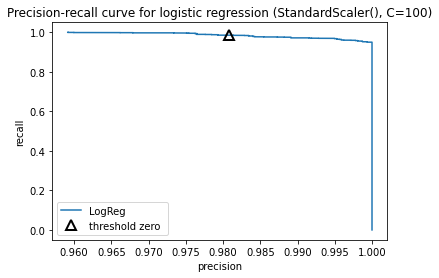

In [20]:
#use best preprocessing (standard scaler) and parameters (c=100) for av. precision
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt
import numpy as np


pipe = Pipeline([('preprocessing', StandardScaler()), 
                 ('classifier', LogisticRegression(C=100, max_iter=10000))])
X_train, X_test, y_train, y_test = train_test_split(features, label, random_state=0)
pipe.fit(X_train, y_train)
predict = (pipe.decision_function(X_test))

precision, recall, thresholds = precision_recall_curve(y_test, predict)

plt.plot(precision, recall, label='LogReg')
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], '^', c='k', 
          markersize=10, label='threshold zero ', fillstyle='none', mew=2)
plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(loc='best')
plt.title('Precision-recall curve for logistic regression (StandardScaler(), C=100)')